Using device: cpu
[Epoch 1, Batch 2000] loss: 2.268
[Epoch 1, Batch 4000] loss: 1.926
[Epoch 1, Batch 6000] loss: 1.696
[Epoch 1, Batch 8000] loss: 1.557
[Epoch 1, Batch 10000] loss: 1.467
[Epoch 1, Batch 12000] loss: 1.376
[Epoch 2, Batch 2000] loss: 1.296
[Epoch 2, Batch 4000] loss: 1.237
[Epoch 2, Batch 6000] loss: 1.206
[Epoch 2, Batch 8000] loss: 1.181
[Epoch 2, Batch 10000] loss: 1.140
[Epoch 2, Batch 12000] loss: 1.091
[Epoch 3, Batch 2000] loss: 1.007
[Epoch 3, Batch 4000] loss: 0.985
[Epoch 3, Batch 6000] loss: 0.996
[Epoch 3, Batch 8000] loss: 0.968
[Epoch 3, Batch 10000] loss: 0.961
[Epoch 3, Batch 12000] loss: 0.932
[Epoch 4, Batch 2000] loss: 0.848
[Epoch 4, Batch 4000] loss: 0.833
[Epoch 4, Batch 6000] loss: 0.843
[Epoch 4, Batch 8000] loss: 0.835
[Epoch 4, Batch 10000] loss: 0.833
[Epoch 4, Batch 12000] loss: 0.822
[Epoch 5, Batch 2000] loss: 0.708
[Epoch 5, Batch 4000] loss: 0.713
[Epoch 5, Batch 6000] loss: 0.734
[Epoch 5, Batch 8000] loss: 0.720
[Epoch 5, Batch 10000]

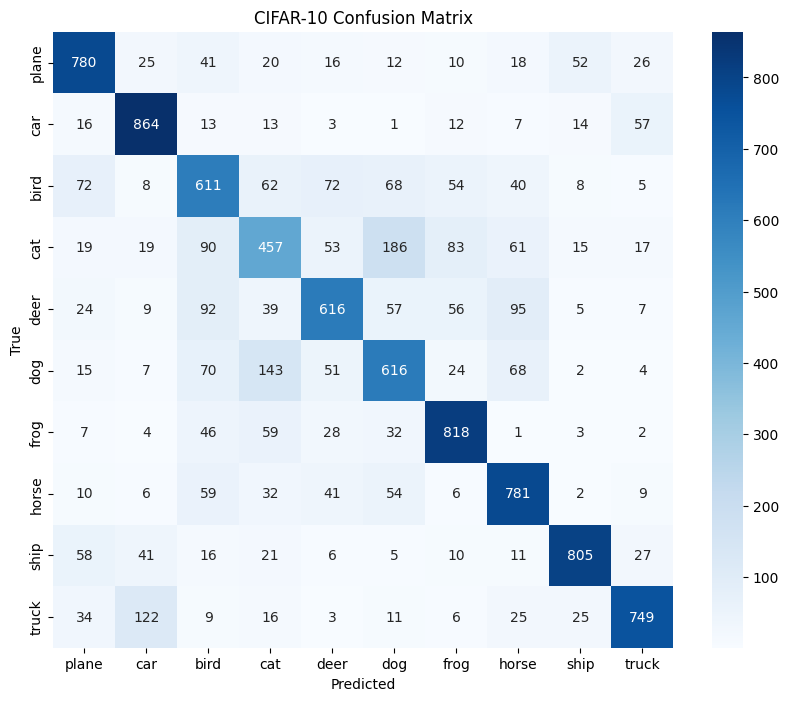

In [1]:
# Colab or script: CIFAR-10 CNN with confusion matrix, fully GPU-compatible

import torch
import torchvision
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1) Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2) Data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

# 3) Datasets & loaders
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

# 4) Model definition
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,5)
        self.pool  = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)
        self.fc1   = nn.Linear(128*1*1,120)
        self.fc2   = nn.Linear(120,84)
        self.fc3   = nn.Linear(84,10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1,128*1*1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

net = Net().to(device)

# 5) Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

numepochs = 20

# 6) Training loop
for epoch in range(numepochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 1):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 0:
            print(f"[Epoch {epoch+1}, Batch {i}] loss: {running_loss/2000:.3f}")
            running_loss = 0.0

print("Finished Training")

# 7) Evaluation + confusion matrix data
all_labels = []
all_preds  = []
correct = 0
total   = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, preds = torch.max(outputs, 1)

        total   += labels.size(0)
        correct += (preds == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print(f"Test Accuracy: {100 * correct/total:.2f}%")

# 8) Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CIFAR-10 Confusion Matrix')
plt.show()
